In [7]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
from IPython.display import display, Image
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
data_root = './dataset'

last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    os.makedirs(data_root, exist_ok=True)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
        'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename  = maybe_download('test.tar.gz', 276555967)
extra_filename = maybe_download('extra.tar.gz', 1955489752)

Found and verified ./dataset/train.tar.gz
Found and verified ./dataset/test.tar.gz
Found and verified ./dataset/extra.tar.gz


In [5]:
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))
    ]
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders  = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)

./dataset/train already present - Skipping extraction of ./dataset/train.tar.gz.
./dataset/test already present - Skipping extraction of ./dataset/test.tar.gz.
./dataset/extra already present - Skipping extraction of ./dataset/extra.tar.gz.


Displaying images in:  train


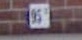

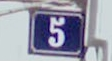

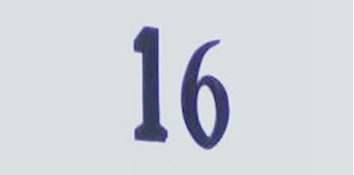

Displaying images in:  extra


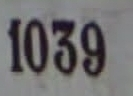

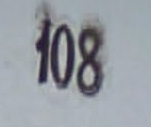

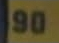

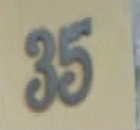

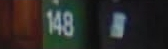

Displaying images in:  test


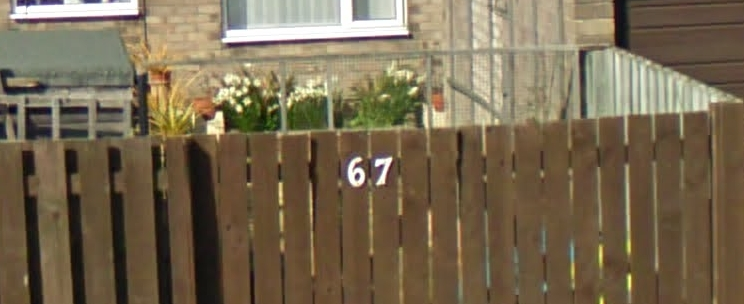

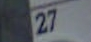

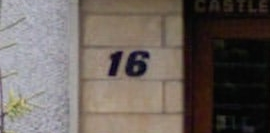

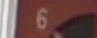

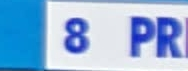

In [11]:
# Visualise a sample of each label
def display_images(folder, samples_per_label):
    print ('Displaying images in: ', folder)
    folder_path = os.path.join(data_root, folder)
    images = os.listdir(folder_path)
    random.shuffle(images)
    for image in images[:samples_per_label]:
        display(Image(filename=os.path.join(folder_path, image), width=80.0, height=80.0))
            
display_images('train', 5)
display_images('extra', 5)
display_images('test', 5)

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [ ]:
image_size = 128  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_dataset(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files  = os.listdir(folder)
    dataset      = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

## Network

In [ ]:
image_size = 32
num_labels = 11
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels  = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset , test_labels  = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

In [ ]:
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
  
    # Variables.
    ## First convolutional layer
    conv1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    conv1_biases  = tf.Variable(tf.zeros([depth]))
    
    ## Second convolutional layer
    conv2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    conv2_biases  = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    ## fully connected layer
    fc1_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    fc1_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    ## softmax
    softmax1_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax1_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax2_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax3_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax3_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax4_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax5_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax5_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        # first conv
        conv   = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
        conv   = tf.nn.relu(conv + conv1_biases)
        hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # second conv
        conv   = tf.nn.conv2d(hidden, conv2_weights, [1, 2, 2, 1], padding='SAME')
        conv   = tf.nn.relu(conv + conv2_biases)
        hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # flatten
        shape   = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # fc
        hidden  = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        
        # classifiers
        classifier1 = tf.matmul(hidden, softmax1_weights) + softmax1_biases
        classifier2 = tf.matmul(hidden, softmax2_weights) + softmax2_biases
        classifier3 = tf.matmul(hidden, softmax3_weights) + softmax3_biases
        classifier4 = tf.matmul(hidden, softmax4_weights) + softmax4_biases
        classifier5 = tf.matmul(hidden, softmax5_weights) + softmax5_biases
        
        return [classifier1, classifier2, classifier3, classifier4, classifier5]
  
    # Training computation.
    logits = model(tf_train_dataset)
    
    losses = []
    for logit in logits:
        losses.append(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)))
    
    # Optimizer.
    optimizers = []
    for loss in losses:
        optmizers.append(tf.train.GradientDescentOptimizer(0.05).minimize(loss))
  
    # Predictions for the training, validation, and test data.
    def prediction(logits):
        prediction = []
        for logit in logits:
            prediction.append(tf.nn.softmax(logit))
        return prediction
    
    train_predictions = prediction(logits)
    valid_predictions = prediction(model(tf_valid_dataset))
    test_predictions  = prediction(model(tf_test_dataset))

In [ ]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset       = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data   = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, losses, predictions = session.run([optimizers, losses, train_predictions], feed_dict=feed_dict)
        if (step % 50 == 0):
            for i in range(5):
                print('digit %d', % (i))
                print('Minibatch loss at step %d: %f' % (step, losses[i]))
                print('Minibatch accuracy: %.1f%%' % accuracy(predictions[i], batch_labels[i]))
                print('Validation accuracy: %.1f%%' % accuracy(valid_predictions.eval()[i], valid_labels[i]))

  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))